['...', '0', 'ablauf', 'abschluss', 'absolut', 'abwicklung', 'anfang', 'anfrage', 'anfragen', 'angebot', 'angebote', 'anliegen', 'ansprechpartner', 'aufwand', 'ausschreibung', 'auszahlung', 'bank', 'banken', 'beantwortet', 'bearbeitet', 'bearbeitung', 'bedarf', 'begleitet', 'begleitung', 'bekommen', 'bemüht', 'beraten', 'berater', 'beratung', 'bestens', 'betreut', 'betreuung', 'danke', 'darlehen', 'direkt', 'einfach', 'einfache', 'empfehlen', 'empfehlenswert', 'empfehlung', 'engagiert', 'engagierte', 'erfahrung', 'erfahrungen', 'erfolg', 'erfolgreich', 'ergebnis', 'erreichbar', 'erreichbarkeit', 'fall', 'finanzierung', 'finanzierungspartnern', 'finden', 'firma', 'fragen', 'frau', 'freundlich', 'freundliche', 'geben', 'gedauert', 'gefunden', 'geholfen', 'geklappt', 'genau', 'gerne', 'gespräch', 'guten', 'hausbank', 'herr', 'herrn', 'hervorragend', 'hervorragende', 'hilfe', 'hilfsbereit', 'innerhalb', 'insbesondere', 'jederzeit', 'klasse', 'kommunikation', 'kompetent', 'kompetente', 'kom

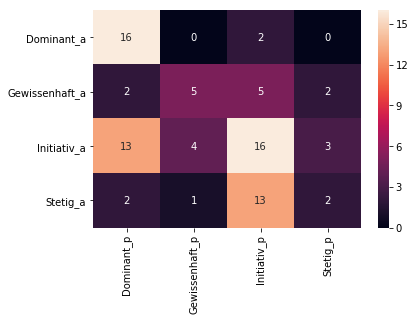

Random Forests Genauigkeit: 0.43023255813953487


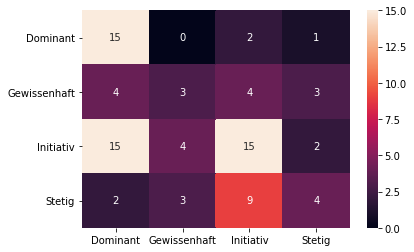

In [13]:
# Pakete importieren
import pandas as pd
import numpy as np

import spacy # Zur Tokenisierung und Lemmatisierung
from spacy.lang.de.stop_words import STOP_WORDS
from spacy.lang.de import German

import string # Um Punktierungen herauszufiltern

# Sklearn hat alle Methoden, die wir brauchen, um die DTM aufzustellen
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Auch die Algorithmen sind in Sklearn implementiert
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Metrics hat eine Methode, um Konfusionsmatrizen zu erzeugen
from sklearn import metrics

# Daten einlesen
reviews = pd.read_csv("reviews.csv", header=0, sep="," )

# Liste der Punktierungen und Stopwörter erzeugen
punctuations = string.punctuation
nlp = spacy.load('de_core_news_sm')
stop_words = STOP_WORDS

# Wir laden einen Parser, der deutsche Sätze interpretieren kann
parser = German()

# Wir wollen unsere csv-Datei tokenizen und danach die einzelnen Tokens lemmatizen und aussortieren
def spacy_tokenizer(doc):
    # Erstellen der Tokens mit Wortinformationen
    mytokens = parser(doc)

    # Lemmatisierung aller Tokens und ersetzen durch Kleinschreibung
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Entfernen der Stopwörter und Interpunktionen
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    
    # Zahlen werden auf 0 gesetzt
    mytokens = [ word if not word.isdigit() else '0' for word in mytokens ]

    # Rückgabe der Tokens
    return mytokens

# Tokenizen und Erstellen der DTM
cv = CountVectorizer(min_df = 0.01 , ngram_range = (1,1), tokenizer = spacy_tokenizer)
text_counts = cv.fit_transform(reviews['text'])
tokens = cv.get_feature_names()

# print(text_counts)
print(tokens)

# Aufstellen der Datenvektoren
# Seed wurde in R festgelegt, wird hier also nur eingelesen
# X_train, X_test, y_train, y_test = train_test_split(text_counts, reviews['type'], test_size=0.2, random_state = 42)
ind = pd.read_csv('id_auswahl.csv', sep = ',', header=0).to_numpy()[:,1] - 1
ind_inv = [x for x in range(439) if x not in ind]
X_train, X_test, y_train, y_test = text_counts[ind], text_counts[ind_inv], reviews['type'][ind], reviews['type'][ind_inv]

# Wir erstellen ein Modell mit Naive Bayes
clf = MultinomialNB().fit(X_train, y_train)
predicted = clf.predict(X_test)
print("Naive Bayes Genauigkeit:", metrics.accuracy_score(y_test, predicted))

# Plotten der Konfusionsmatrizen
import seaborn as sn
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(y_test, predicted, labels=["Dominant", "Gewissenhaft", "Initiativ", "Stetig"])
df_cm = pd.DataFrame(cm, index = [i for i in ["Dominant_a", "Gewissenhaft_a", "Initiativ_a", "Stetig_a"]],
                  columns = [i for i in ["Dominant_p", "Gewissenhaft_p", "Initiativ_p", "Stetig_p"]])
sn.heatmap(df_cm, annot=True)
plt.show()

#  Mit einer Genauigkeit von 41.6% sehen wir, dass Naive Bayes ein grottiger Ansatz ist.
# Wir erstellen ein Modell mit 10 Decision Trees
rf = RandomForestClassifier( n_estimators = 1000, random_state = 1 )
rf.fit(X_train, y_train);
predictions = rf.predict(X_test)
print("Random Forests Genauigkeit:", metrics.accuracy_score(y_test, predictions))

# Vorhersagen via Random Forests


# Plotten der Konfusionsmatrizen
cm = metrics.confusion_matrix(y_test, predictions, labels=["Dominant",  "Gewissenhaft", "Initiativ", "Stetig"])
df_cm = pd.DataFrame(cm, index = [i for i in ["Dominant", "Gewissenhaft", "Initiativ", "Stetig"]],
                  columns = [i for i in ["Dominant", "Gewissenhaft", "Initiativ", "Stetig"]])
sn.heatmap(df_cm, annot=True)
plt.show()
